In [0]:
# Code adapted from: Lars Nieradzik's code on Object Localization https://github.com/lars76/object-localization 
#    under MIT License

# Data: The Oxford-IIIT Pet Dataset http://www.robots.ox.ac.uk/~vgg/data/pets/ 
#    under Creative Commons License https://creativecommons.org/licenses/by-sa/4.0/

In [0]:
# IMPORT LIBRARIES AND PACKAGES

import csv
import math
import cv2

import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [0]:
# SETTINGS

ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

EPOCHS = 1
BATCH_SIZE = 4
PATIENCE = 10

THREADS = 1

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
project_path = "/content/drive/My Drive/AIML Notes/BoundingBox/"

In [0]:
images_zip_path = project_path + "images.zip"

from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [0]:
DATASET_FOLDER = "./images/"
TRAIN_CSV = project_path + "train.csv"
VALIDATION_CSV = project_path + "validation.csv"

In [0]:
class DataGenerator(Sequence):

    def __init__(self, csv_file):
        self.paths = []

        with open(csv_file, "r") as file:
            self.mask = np.zeros((sum(1 for line in file), HEIGHT_CELLS, WIDTH_CELLS))
            file.seek(0)

            reader = csv.reader(file, delimiter=",")

            for index, row in enumerate(reader):
                for i, r in enumerate(row[1:7]):
                    row[i+1] = int(r)

                path, image_height, image_width, x0, y0, x1, y1, _, _ = row
                path = "./" + path.split("/")[-2] + "/" + path.split("/")[-1]
                path_mask = path.replace('.jpg','.png')

                mask_img = cv2.imread(path_mask)
                mask_img = (mask_img!=2)*1.0
                mask_img = cv2.resize(mask_img, (28, 28))
                mask_img = 1.0*(mask_img[:,:,0]>0.2)
                self.mask[index,:,:] = np.squeeze(mask_img)
                
                self.paths.append(path)

    def __len__(self):
        return math.ceil(len(self.mask) / BATCH_SIZE)

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_masks = self.mask[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]

        batch_images = np.zeros((len(batch_paths), IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
            img = img.convert('RGB')

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            img.close()

        return batch_images, batch_masks

In [0]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [0]:
model = create_model(False)
model.summary()

train_datagen = DataGenerator(TRAIN_CSV)
validation_datagen = DataGenerator(VALIDATION_CSV)

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="auto")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalizationV1) (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________________

In [0]:
model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    validation_data=validation_datagen,
                    callbacks=[checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=False,
                    shuffle=True,
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
170/170 [==============================] - 6s 34ms/step - loss: 0.7137 - dice_coefficient: 0.7434

Epoch 00001: val_loss improved from inf to 0.71373, saving model to model-0.71.h5
752/752 [==============================] - 34s 46ms/step - loss: 1.0531 - dice_coefficient: 0.6462 - val_loss: 0.7137 - val_dice_coefficient: 0.7434


In [0]:
# TESTING

import cv2
import numpy as np

from keras.applications.mobilenet import preprocess_input

Using TensorFlow backend.


In [0]:
WEIGHTS_FILE = "model-0.71.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)

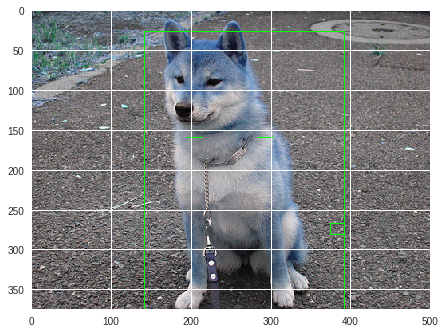

In [0]:
# import matplotlib.pyplot as plt
# filename = './images/shiba_inu_163.jpg'

# unscaled = cv2.imread(filename)
# image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
# feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

# region = model.predict(x=np.array([feat_scaled]))[0]

# output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
# for i in range(region.shape[1]):
#     for j in range(region.shape[0]):
#         if region[i][j] > THRESHOLD:
#             x = int(CELL_WIDTH * j * unscaled.shape[1] / IMAGE_WIDTH)
#             y = int(CELL_HEIGHT * i * unscaled.shape[0] / IMAGE_HEIGHT)
#             x2 = int(CELL_WIDTH * (j + 1) * unscaled.shape[1] / IMAGE_WIDTH)
#             y2 = int(CELL_HEIGHT * (i + 1) * unscaled.shape[0] / IMAGE_HEIGHT)
# #             cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)

#             output[y:y2,x:x2] = 1

# _, contours, _ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# for cnt in contours:
#     approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
#     x, y, w, h = cv2.boundingRect(approx)
#     cv2.rectangle(unscaled, (x, y), (x + w, y + h), (0, 255, 0), 1)

# plt.imshow(unscaled)

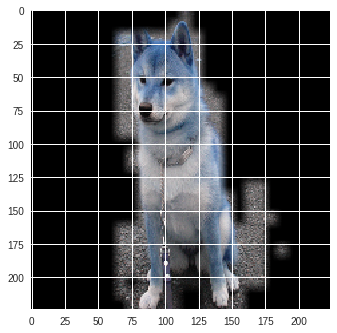

In [0]:
filename = './images/shiba_inu_163.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)